# Clinical-bert classifier 

The goal of this notebook is to fine tune a pretrained [Clinical Bert model in spanish](https://huggingface.co/PlanTL-GOB-ES/roberta-base-biomedical-clinical-es) in a breast cancer mamography reports dataset in order to classify each report according to whether cancer was developed in the future or not. (binary classification).
The proposed architecture looks as follows: 



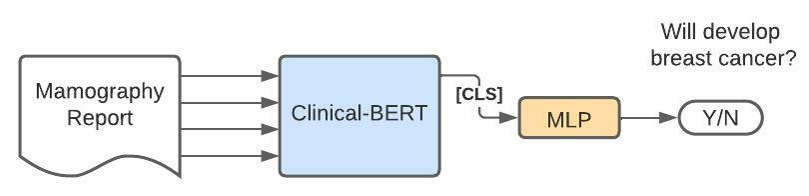

In [121]:
from datasets import load_dataset
from transformers import AutoModel
import torch
import numpy as np
model_ckpt="PlanTL-GOB-ES/roberta-base-biomedical-clinical-es" # Model ch

## Loading the dataset
This may be outsourced to a class of it's own or to the prepare script. 

In [46]:
train_path='../data/clean/BreastCancer_train.csv'
validation_path='../data/clean/BreastCancer_validation.csv'
test_path='../data/clean/BreastCancer_test.csv'

# Not currently using test because of few data
dataset=load_dataset('csv', data_files={'train': train_path, 'validation':validation_path}) 

Using custom data configuration default-6979c44da4f42a71


Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1548.28it/s]


Dataset csv downloaded and prepared to /home/jupyter/.cache/huggingface/datasets/csv/default-6979c44da4f42a71/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 603.89it/s]


In [52]:
# The target corresponds to column 'BRCAEvent
dataset

DatasetDict({
    train: Dataset({
        features: ['REPORT', 'BRCAEvent', 'Year', 'AGE', 'DaysToEvent'],
        num_rows: 165
    })
    validation: Dataset({
        features: ['REPORT', 'BRCAEvent', 'Year', 'AGE', 'DaysToEvent'],
        num_rows: 70
    })
})

## Preparing dataset

### Getting tokenizer features

In [53]:
from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained('PlanTL-GOB-ES/roberta-base-biomedical-clinical-es')

In [56]:
def tokenize(batch):
    return tokenizer(batch['REPORT'],padding=True,truncation=True)

In [62]:
dataset_encoded=dataset.map(tokenize,batched=True)

100%|██████████| 1/1 [00:00<00:00, 128.77ba/s]


## Load the Model

In [74]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at PlanTL-GOB-ES/roberta-base-biomedical-clinical-es were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-biomedical-clinical-es and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably

## Extract hidden states

In [79]:
# Make the dataset into pytorch format
dataset_encoded.set_format('torch',columns=['input_ids','attention_mask'])

In [111]:
def get_contextual_embeddings(batch):
    inputs={k:v.to(device) for k,v in batch.items() if k in 
    tokenizer.model_input_names}
    with torch.no_grad():
        outputs=model(**inputs).last_hidden_state[:,0]
    return {'hidden_state':outputs.cpu().numpy()}
        
    

In [115]:
dataset_hidden=dataset_encoded.map(get_contextual_embeddings,batched=True)

Loading cached processed dataset at /home/jupyter/.cache/huggingface/datasets/csv/default-6979c44da4f42a71/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f9d509d522f3bc53.arrow
Loading cached processed dataset at /home/jupyter/.cache/huggingface/datasets/csv/default-6979c44da4f42a71/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-aaab9a1a9216ef29.arrow


### Reduce dimentionality of the hidden states

In [124]:
from umap import UMAP
hidden_states=np.array(dataset_hidden['train']['hidden_state'])

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(2))
cmaps=['Blues','Reds']
labels=['No-Cancer','Cancer']

for i,(label,cmap) in enumerate(zip(labels,cmaps)):
    df_emb_sub=